In [2]:
import numpy as np
import shapely
import json
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
import rasterio
import rasterio.plot as rplt
from rasterio.crs import CRS
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio.io import MemoryFile
import rasterio.windows  as rw
from rasterio.enums import Resampling
from rasterio.transform import Affine
from scipy.spatial import cKDTree
from skimage import (color, data, filters, measure, morphology, segmentation,
                     util)
from matplotlib_scalebar.scalebar import ScaleBar
from typing import List, Any
import os
import pandas as pd

import sgl_processor_v03 as sgl # type: ignore
import sgl_utils # type: ignore
import geopandas as gpd

ModuleNotFoundError: No module named 'sgl_processor_v03'

In [2]:
settings = sgl.ProcessorSGLSettings()
settings.rangestart = "20191201"
settings.rangeend = "20200331"
processorSGL = sgl.initialize(settings)
metas = sgl.get_metadata_from_csv(settings.season_folder, ["tile-181", "tile-182", "tile-183"])
coll = sgl.create_collection_from_meta(settings, "shackleton1920", metas)

X=====================================================
SGLProcessor started for 20191201 to 20200331
X=====================================================
=====> Get metadata from .csv files.
=====> Create collection from csv meta.
     | 69 windows created for collection.


In [3]:
sgl.combine_filter_drainages(settings, coll, print_metadata = True)
drains = gpd.read_file(r"D:\[NOT SYNC]\ASRP_Data\shackleton_sgl_20201201_20210331\L8S2_20201201_20210331_drain.shp")

=====> Combine and filter drainages.


d:\Programme\Anaconda\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


     | tile-181
     |  3084 -> raw
     |   518 -> filtered by time difference of max 10 days
     |   398 -> within melting period
     |   194 -> valid satellite combination
     |   194 -> filterd by minimum lake area 0.054 km2


d:\Programme\Anaconda\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
d:\Programme\Anaconda\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


     | tile-182
     |   721 -> raw
     |   188 -> filtered by time difference of max 10 days
     |    86 -> within melting period
     |    43 -> valid satellite combination
     |    43 -> filterd by minimum lake area 0.054 km2
     | tile-183
     |   218 -> raw
     |    39 -> filtered by time difference of max 10 days
     |    26 -> within melting period
     |     5 -> valid satellite combination
     |     5 -> filterd by minimum lake area 0.054 km2
     |
     |   242 -> combined events
=====> Check L8 / S2 images for cloud cover.
     |   216 -> lakes to remove (nodepth : 64 | shallow : 131 | std : 4 | clouds-0 : 5 | clouds-1 : 12).
     |    26 -> Cloud cover checked.


d:\Programme\Anaconda\lib\site-packages\geopandas\io\file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [4]:
lakeextent = gpd.read_file(r"D:\[NOT SYNC]\ASRP_Data\shackleton_sgl_20201201_20210331\L8S2_20201201_20210331_lakeextent.shp")
dmgs = gpd.read_file(r"D:\[NOT SYNC]\ASRP_Data\shackleton_S1_30m\S1_20201201_20210331_dmg_5.shp")
#gdf_labels = pd.read_excel(r"D:\OneDrive\02_Standards\[Code]\01_Projects\ASRP_Antarctic-Remote-Sensing-1\202_OutputSGL\shackleton_sgl_20191201_20200331\drain_labels_v1.xlsx")
#drain_labels = dict(zip(gdf_labels[gdf_labels["window"] == 0]["criteria"], gdf_labels[gdf_labels["window"] == 0]["drainage"]))
#positive_drains = [k for k, v in drain_labels.items() if v == 1]
ice = gpd.read_file(r"D:\[NOT SYNC]\ASRP_Data\shackleton\ice_shelves.geojson").to_crs(settings.crs_ant_str)

In [5]:
crevs = processorSGL.get_vectorized_crevasse(coll, print_bool = True, target = 45, spread = 15)
active_crevs = gpd.GeoDataFrame(pd.concat([d["data active"] for d in crevs]))  # type: ignore
active_crevs.set_crs(crevs[0]["data active"].crs)  # type: ignore
inactive_crevs = gpd.GeoDataFrame(pd.concat([d["data inactive"] for d in crevs]))  # type: ignore
inactive_crevs.set_crs(crevs[0]["data inactive"].crs)   # type: ignore
print(f"     | {active_crevs.shape[0]:>6d} vs {inactive_crevs.shape[0]:>6d} with {dmgs_combined.crs}")

=====> Get vectorized active crevasses for 45° (15°).
     |  15908 |  35522 | tile-181_delta-alpha.tif
     |  20707 |  34195 | tile-182_delta-alpha.tif
     |   7236 |  17401 | tile-183_delta-alpha.tif
     |  43851 vs  87118 with EPSG:3031


In [9]:
def ckdnearest_SGLfromCREV(gdSGL, gdCREV, number_nearest_crev: int = 1):
    gdSGL = gdSGL.reset_index(drop=True)
    nSGL = np.array(list(gdSGL["geometry"].centroid.apply(lambda x: (x.x, x.y))))

    nCREV = np.array(list(gdCREV["geometry"].centroid.apply(lambda x: (x.x, x.y))))
    CREVtree = cKDTree(nCREV)
    dist, idx = CREVtree.query(nSGL, k=number_nearest_crev)
    if idx.ndim > 1:
        gdCREV_nearest = gdCREV.iloc[idx[0]].rename(columns={"geometry" : "crev-geometry"}).reset_index(drop=True)
        gdf = pd.concat(
            [
                gdSGL.reset_index(drop=True).rename(columns={"geometry" : "sgl-geometry"}),
                pd.Series(dist.mean(axis = 1), name='dist-lake-crev'),
                gdCREV_nearest
                
            ], 
            axis=1)
    else:
        gdCREV_nearest = gdCREV.iloc[idx].rename(columns={"geometry" : "crev-geometry"}).reset_index(drop=True)

        gdf = pd.concat(
            [
                gdSGL.reset_index(drop=True).rename(columns={"geometry" : "sgl-geometry"}),
                pd.Series(dist, name='dist-lake-crev'),
                gdCREV_nearest,
                
            ], 
            axis=1)

    return gdf

In [10]:
distance_SGLfromCREV_active = ckdnearest_SGLfromCREV(lakeextent, active_crevs, number_nearest_dmg = 1)
distance_SGLfromCREV_inactive = ckdnearest_SGLfromCREV(lakeextent, inactive_crevs, number_nearest_dmg = 1)

In [13]:
distance_DRAINfromCREV_active = ckdnearest_SGLfromCREV(drains[drains["window"] == 0], active_crevs, number_nearest_dmg = 1)
distance_DRAINfromCREV_inactive = ckdnearest_SGLfromCREV(drains[drains["window"] == 0], inactive_crevs, number_nearest_dmg = 1)

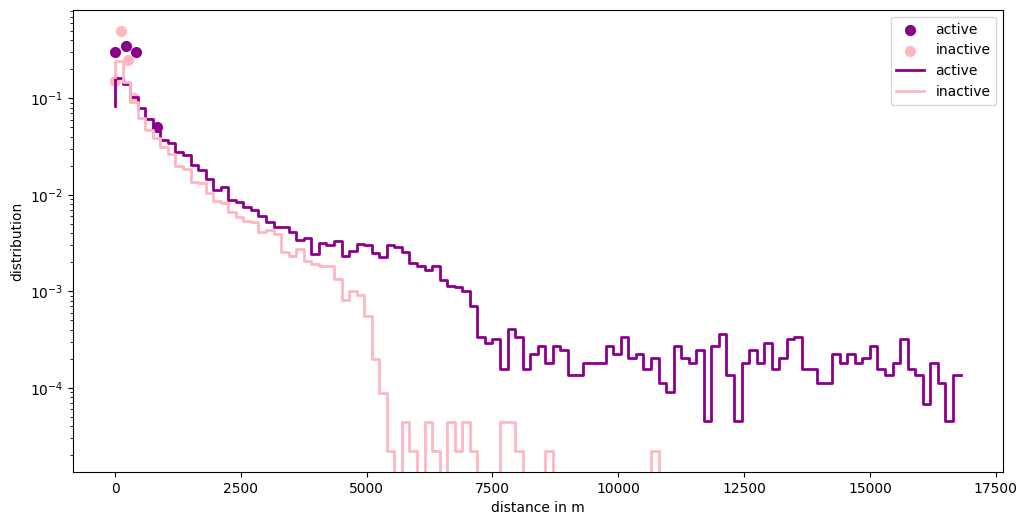

In [23]:
bin_limits_sgl = np.arange(0, max(distance_SGLfromCREV_active['dist-lake-crev']) // 4, 300/2)

fig, ax = plt.subplots(figsize = (12, 6))
maximum_active = max(distance_DRAINfromCREV_active['dist-lake-crev'])
bin_limits_drains_active = np.arange(0, maximum_active, maximum_active // 5)
count_drains_active, division_drains_active = np.histogram(distance_DRAINfromCREV_active['dist-lake-crev'], bins = bin_limits_drains_active)
count_drains_active_sum = np.array(count_drains_active).sum()
ax.scatter(division_drains_active[:-1], np.array(count_drains_active) / count_drains_active_sum, lw = 2, label = f"active", color = "darkmagenta")

maximum_inactive = max(distance_DRAINfromCREV_inactive['dist-lake-crev'])
bin_limits_drains_inactive = np.arange(0, maximum_inactive, maximum_inactive // 5)
count_drains_inactive, division_drains_inactive = np.histogram(distance_DRAINfromCREV_inactive['dist-lake-crev'], bins = bin_limits_drains_inactive)
count_drains_inactive_sum = np.array(count_drains_inactive).sum()
ax.scatter(division_drains_inactive[:-1], np.array(count_drains_inactive) / count_drains_inactive_sum, lw = 2, label = f"inactive", color = "lightpink")


count_sgl_active, division_sgl_active = np.histogram(distance_SGLfromCREV_active['dist-lake-crev'], bins = bin_limits_sgl)
count_sgl_active_sum = np.array(count_sgl_active).sum()
ax.step(division_sgl_active[:-1], np.array(count_sgl_active) / count_sgl_active_sum, lw = 2, label = f"active", color = "darkmagenta")

count_sgl_inactive, division_sgl_inactive = np.histogram(distance_SGLfromCREV_inactive['dist-lake-crev'], bins = bin_limits_sgl)
count_sgl_inactive_sum = np.array(count_sgl_inactive).sum()
ax.step(division_sgl_inactive[:-1], np.array(count_sgl_inactive) / count_sgl_inactive_sum, lw = 2, label = f"inactive", color = "lightpink")

ax.set_xlabel("distance in m")
ax.set_ylabel("distribution")
#ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
plt.show()